In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import copy

### Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
seoul_bike_sharing_demand = fetch_ucirepo(id=560)

# data (as pandas dataframes)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets

# metadata
print(seoul_bike_sharing_demand.metadata)

# variable information
print(seoul_bike_sharing_demand.variables)


{'uci_id': 560, 'name': 'Seoul Bike Sharing Demand', 'repository_url': 'https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand', 'data_url': 'https://archive.ics.uci.edu/static/public/560/data.csv', 'abstract': 'The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information', 'area': 'Business', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 8760, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Functioning Day'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5F62R', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and a

In [ ]:
df = X.drop(['Date', 'Holiday', 'Seasons'], axis=1)

In [ ]:
df['functional'] = y
df['functional'] = (df['functional'] == 'Yes').astype(int)

In [ ]:
df = df[df['Hour'] == 12]
df = df.drop('Hour', axis=1)

In [ ]:
df.head()

,Rented Bike Count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


In [ ]:
df = df.drop(["Wind speed", "functional", "Visibility"], axis=1)

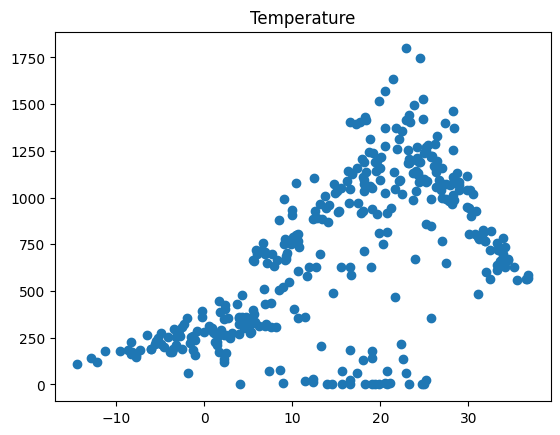

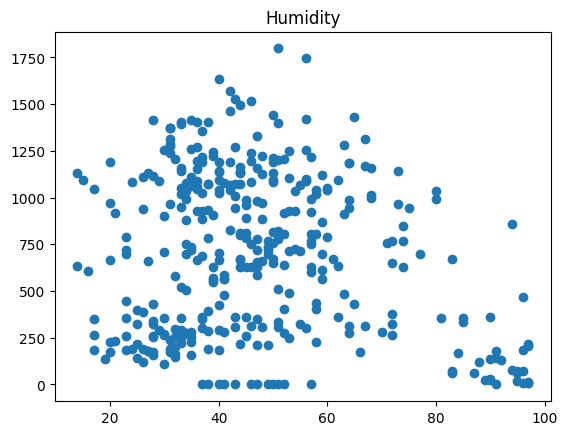

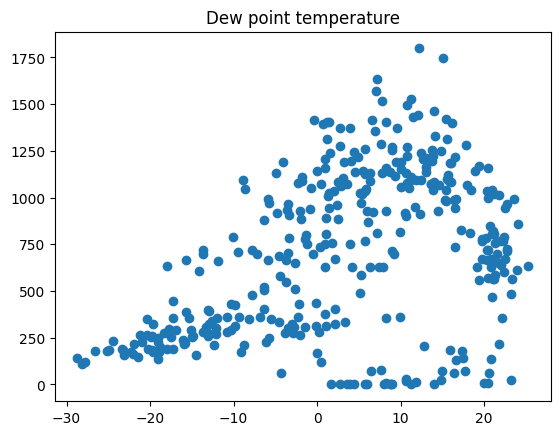

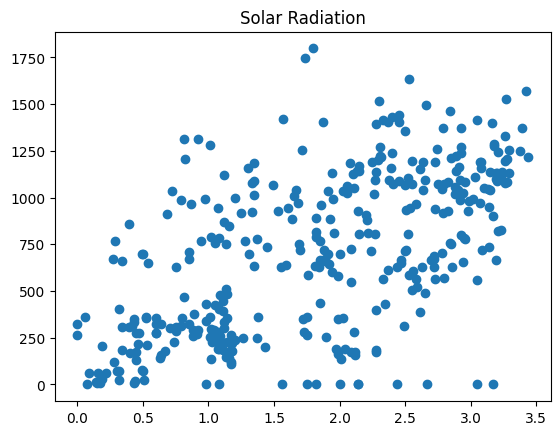

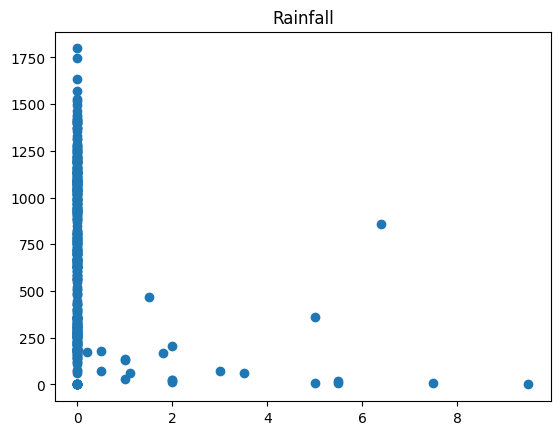

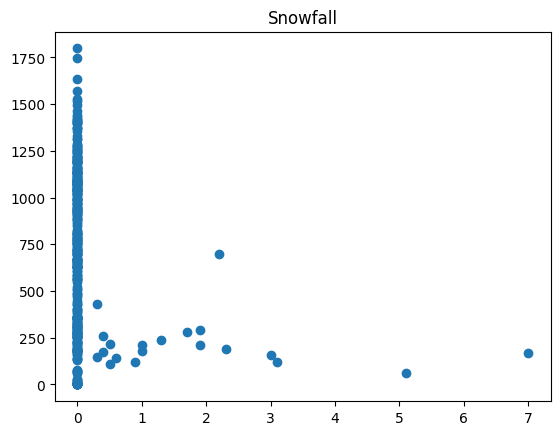

In [ ]:
for lable in df.columns[1:]:
  plt.scatter(df[lable], df['Rented Bike Count'])
  plt.title(lable)
  plt.show()

# Train, Valid, Test dataset

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
def get_xy(df, y_label, x_labels=None):
  df = copy.deepcopy(df)
  if x_labels is None:
    X = df[[c for c in df.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      X = df[x_labels[0]].values.reshape(-1, 1)
    else:
      X = df[x_labels].values

    y = df[y_label].values.reshape(-1, 1)

    data = np.hstack((X, y))

  return data, X, y

In [ ]:
_, X_train_temp, y_train_temp = get_xy(train, 'Rented Bike Count', x_labels=['Temperature'])
_, X_val_temp, y_val_temp = get_xy(val, 'Rented Bike Count', x_labels=['Temperature'])
_, X_test_temp, y_test_temp = get_xy(test, 'Rented Bike Count', x_labels=['Temperature'])

In [ ]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [ ]:
temp_reg.score(X_test_temp, y_test_temp)

0.3710751612545078

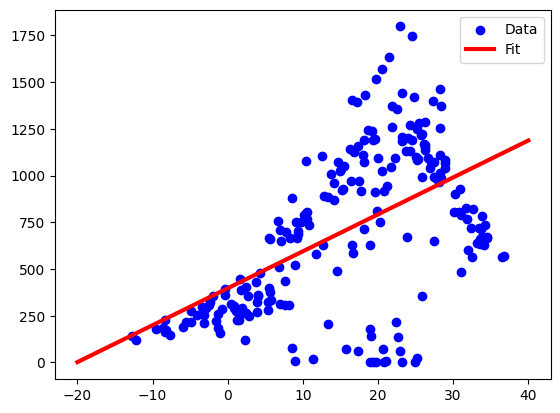

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x.numpy().reshape(-1,1), temp_reg.predict(x.numpy().reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.show()

# Multiple Linear Regression

In [ ]:
_, X_train_all, y_train_all = get_xy(train, 'Rented Bike Count', x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'Rented Bike Count', x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'Rented Bike Count', x_labels=df.columns[1:])

In [ ]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [ ]:
all_reg.score(X_test_all, y_test_all)

0.4533419264029771

# Regression with Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)

In [ ]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])

In [ ]:
temp_nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)

In [ ]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

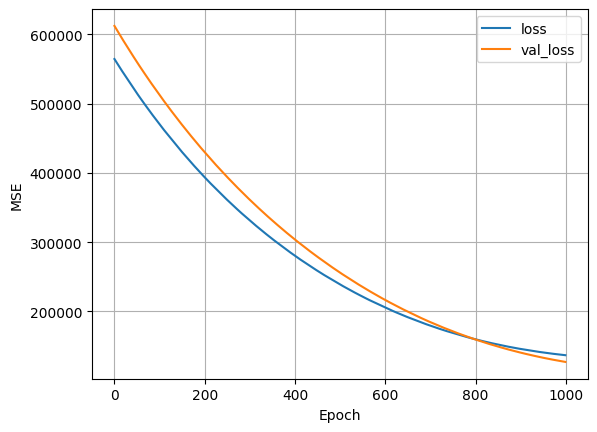

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


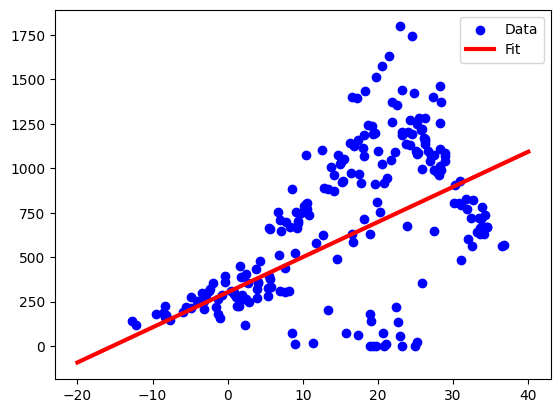

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x.numpy().reshape(-1,1), temp_nn_model.predict(x.numpy().reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.show()

# Neural Net

In [ ]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=100,
    verbose=0,
    validation_data=(X_val_temp, y_val_temp)
)

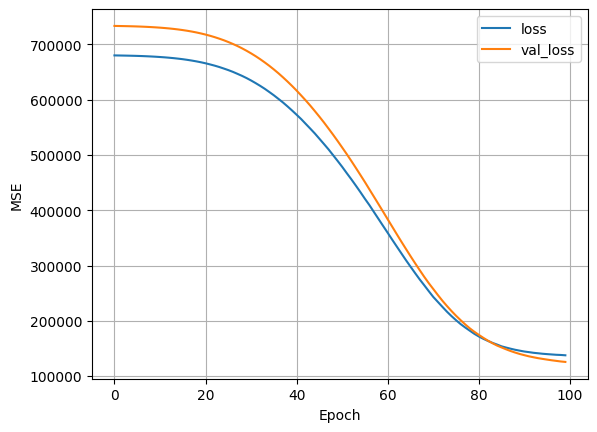

In [ ]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


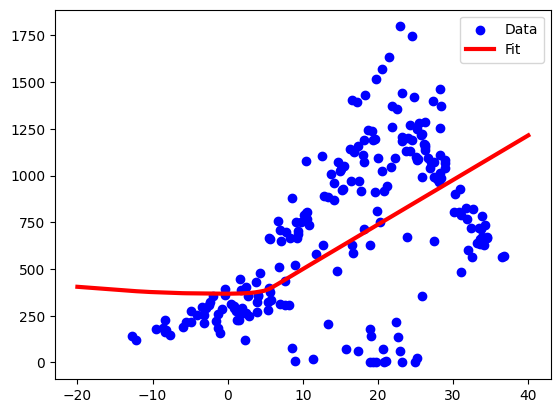

In [ ]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x.numpy().reshape(-1,1), nn_model.predict(x.numpy().reshape(-1,1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.show()

In [ ]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])
nn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

In [ ]:
history = nn_model.fit(
    X_train_all, y_train_all,
    epochs=100,
    verbose=0,
    validation_data=(X_val_all, y_val_all)
)

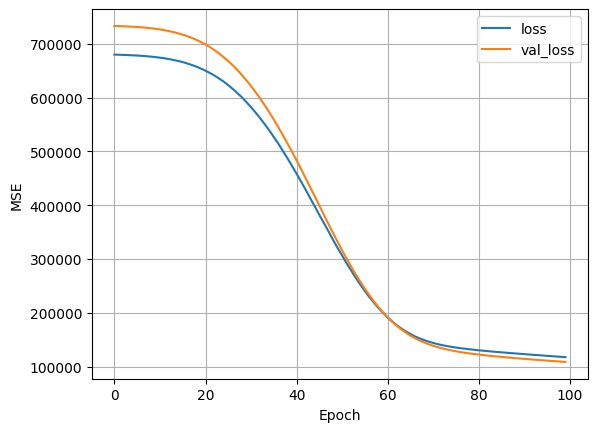

In [ ]:
plot_loss(history)

# Calculate the MSE for Linear regression and Neural Network

In [ ]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [ ]:
def MSE(y_pred, y_test):
  return (np.square(y_pred - y_test)).mean()

In [ ]:
MSE(y_pred_lr, y_test_all)

np.float64(111624.10562124249)

In [ ]:
MSE(y_pred_nn, y_test_all)

np.float64(125063.9105552278)